<a href="https://colab.research.google.com/github/gdnsjf/educational-work/blob/main/%20RNN%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Используя тип нейронной сети RNN LSTM - сделайте прогноз развития уровня
углекислого газа, используя следующие данные.
Поле "interpolated" содержит тренд развития уровня CO2, поля "year" и "month" содержат год и месяц соответственно.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('co2_mm_mlo(1).csv', delimiter=';')

# Преобразование года и месяца в дату
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

# Сортировка данных по дате
data = data.sort_values('date')

# Извлечение нужных столбцов
data = data[['date', 'interpolated']]
data.set_index('date', inplace=True)

# Нормализация данных
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Преобразование данных в форматы для обучения LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(data_scaled, time_step)

# Преобразование входных данных в нужный формат для LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Прогнозирование на основе последних 12 месяцев данных
last_12_months = data_scaled[-time_step:]
last_12_months = last_12_months.reshape(1, time_step, 1)

predicted_co2 = model.predict(last_12_months)
predicted_co2 = scaler.inverse_transform(predicted_co2)

print(f'Прогнозируемый уровень CO2: {predicted_co2[0][0]}')

Epoch 1/100
18/18 [==============================] - 5s 66ms/step - loss: 0.0303 - val_loss: 0.0477
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 8.5338e-04
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 7.3576e-04 - val_loss: 9.8747e-04
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 6.6995e-04 - val_loss: 9.0368e-04
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss: 6.4744e-04 - val_loss: 9.1593e-04
Epoch 7/100
18/18 [==============================] - 0s 25ms/step - loss: 6.5861e-04 - val_loss: 7.1495e-04
Epoch 8/100
18/18 [==============================] - 0s 24ms/step - loss: 6.5105e-04 - val_loss: 7.1101e-04
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 6.4385e-04 - val_loss: 7.3336e-04
Epoch 10/100
18/18 [============================

5/5 [==============================] - 0s 5ms/step


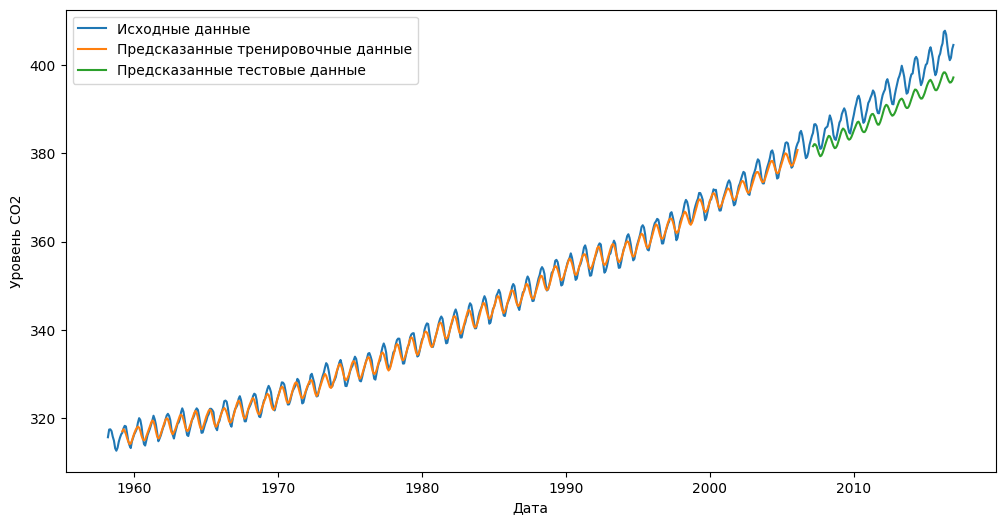

In [ ]:
# Подготовка данных для графика
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size - time_step

train_data = data_scaled[:train_size + time_step]
test_data = data_scaled[train_size:]

train_X, train_y = create_dataset(train_data, time_step)
test_X, test_y = create_dataset(test_data, time_step)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Обратное масштабирование
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Пересчет индексов для графика
train_predict_indices = data.index[time_step:train_size+time_step]
test_predict_indices = data.index[train_size+time_step*2:train_size+time_step*2+len(test_predict)]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['interpolated'], label='Исходные данные')
plt.plot(train_predict_indices, train_predict[:, 0], label='Предсказанные тренировочные данные')

# Убедимся, что длины индексов и предсказанных данных совпадают
if len(test_predict_indices) > len(test_predict[:, 0]):
    test_predict_indices = test_predict_indices[:len(test_predict[:, 0])]
else:
    test_predict = test_predict[:len(test_predict_indices)]

plt.plot(test_predict_indices, test_predict[:, 0], label='Предсказанные тестовые данные')
plt.xlabel('Дата')
plt.ylabel('Уровень CO2')
plt.legend()
plt.show()